# Tugas Mata Kuliah Deep Learning

### **Nama Anggota Kelompok:**
1. Ahmad Zaki (225150201111025)  
2. Muhammad Razi Al Kindi Nadra (225150207111107)  
3. Arion Syemael Siahaan (225150207111060)  

- Model: Fully Connected Neural Network (FCNN)
- Oversampling: SMOTE
- Optimizer: Adam
- Validasi Silang: K-fold cross-validation
- Metode Tambahan: Learning rate scheduler, L1L2 regularizer
- Fungsi Loss: Focal Loss

Data Understanding dan Preliminary Analysis

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K
import seaborn as sns
from tensorflow.keras.layers import Input, Bidirectional, Attention
from tensorflow.keras.models import Model

Focal Loss Implementation

In [44]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, dtype=K.floatx())
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred) + K.epsilon()
        loss = -alpha_t * K.pow(1 - p_t, gamma) * K.log(p_t)
        return K.mean(loss)
    return focal_loss_fixed

Create LSTM Model

In [45]:
# Mekanisme Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        query, value = inputs
        score = tf.matmul(query, value, transpose_b=True)
        alignment = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(alignment, value)
        return context

In [46]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Input, Bidirectional
from tensorflow.keras.models import Model

# Modifikasi Model LSTM
def create_bidirectional_lstm_with_attention(input_shape, dropout_rate=0.4):
    input_layer = Input(shape=input_shape)
    lstm_output = Bidirectional(
        layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(1e-4))
    )(input_layer)
    attention_output = AttentionLayer()([lstm_output, lstm_output])

    # Tambahkan GlobalAveragePooling1D untuk mereduksi dimensi
    pooling_output = GlobalAveragePooling1D()(attention_output)

    dense_output = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l1_l2(1e-5, 1e-4))(pooling_output)
    dropout_layer = layers.Dropout(dropout_rate)(dense_output)
    output_layer = layers.Dense(1, activation="sigmoid")(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=False
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()],
    )

    return model

Precision-Recall Curve

In [47]:
def plot_pr_curve(y_true, y_pred_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

Training with K-Fold Cross Validation

In [48]:
def train_bidirectional_lstm_with_attention(X, y, timesteps, n_splits=5):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    histories = []
    models = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        print(f"\nFold {fold + 1}/{n_splits}")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Reshape data for LSTM
        X_train = X_train.reshape(-1, timesteps, X_train.shape[1] // timesteps)
        X_val = X_val.reshape(-1, timesteps, X_val.shape[1] // timesteps)

        # Apply SMOTE
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(
            X_train.reshape(X_train.shape[0], -1), y_train
        )
        X_train_balanced = X_train_balanced.reshape(-1, timesteps, X_train.shape[2])

        # Ubah dimensi y_train_balanced dan y_val menjadi (batch_size, 1)
        y_train_balanced = y_train_balanced.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)

        # Periksa bentuk tensor
        print(f"X_train_balanced shape: {X_train_balanced.shape}")
        print(f"y_train_balanced shape: {y_train_balanced.shape}")

        # Calculate class weights
        class_weights = dict(enumerate(np.bincount(y_train_balanced.ravel()).max() / np.bincount(y_train_balanced.ravel())))

        # Create and train model
        model = create_bidirectional_lstm_with_attention((timesteps, X_train.shape[2]))
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=5, restore_best_weights=True
            )
        ]

        history = model.fit(
            X_train_balanced,
            y_train_balanced,
            epochs=10,
            batch_size=32,
            verbose=1,
            validation_data=(X_val, y_val),
            class_weight=class_weights,
            callbacks=callbacks
        )

        histories.append(history.history)
        models.append(model)

    return models, histories

Main Pipeline

In [49]:
X_df = pd.read_csv('../kiw/processed_features.csv')
y_df = pd.read_csv('../kiw/processed_labels.csv')

X = X_df.values
y = y_df.values.ravel() 

In [50]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Dynamic memory allocation enabled.")
    except RuntimeError as e:
        print(e)

import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

Dynamic memory allocation enabled.


Train model with k-fold

In [51]:
timesteps = 20
X_reshaped = np.hstack([X] * timesteps)  # Simulate sequential data

models, histories = train_bidirectional_lstm_with_attention(X_reshaped, y, timesteps)


Fold 1/5
X_train_balanced shape: (2859488, 20, 15)
y_train_balanced shape: (2859488, 1)
Epoch 1/10


2024-12-23 07:17:16.103412: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-80GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82977161216 bandwidth: 2039040000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


89356/89359 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9433 - precision_4: 0.9806 - recall_4: 0.9045 - auc_4: 0.9915

2024-12-23 07:25:27.606488: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-80GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82977161216 bandwidth: 2039040000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


89359/89359 [==============================] - 529s 6ms/step - loss: 0.0151 - accuracy: 0.9433 - precision_4: 0.9806 - recall_4: 0.9045 - auc_4: 0.9915 - val_loss: 0.0128 - val_accuracy: 0.9832 - val_precision_4: 0.4008 - val_recall_4: 0.9023 - val_auc_4: 0.9919
Epoch 2/10
89359/89359 [==============================] - 533s 6ms/step - loss: 0.0138 - accuracy: 0.9477 - precision_4: 0.9829 - recall_4: 0.9112 - auc_4: 0.9928 - val_loss: 0.0128 - val_accuracy: 0.9832 - val_precision_4: 0.4006 - val_recall_4: 0.9023 - val_auc_4: 0.9919
Epoch 3/10
89359/89359 [==============================] - 520s 6ms/step - loss: 0.0138 - accuracy: 0.9477 - precision_4: 0.9830 - recall_4: 0.9111 - auc_4: 0.9928 - val_loss: 0.0128 - val_accuracy: 0.9832 - val_precision_4: 0.4006 - val_recall_4: 0.9023 - val_auc_4: 0.9919
Epoch 4/10
89359/89359 [==============================] - 520s 6ms/step - loss: 0.0138 - accuracy: 0.9477 - precision_4: 0.9830 - recall_4: 0.9111 - auc_4: 0.9928 - val_loss: 0.0128 - val_a

2024-12-23 08:10:03.341928: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-80GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82977161216 bandwidth: 2039040000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


89357/89360 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9453 - precision_5: 0.9804 - recall_5: 0.9087 - auc_5: 0.9915

2024-12-23 08:19:11.642511: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-80GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82977161216 bandwidth: 2039040000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


89360/89360 [==============================] - 588s 7ms/step - loss: 0.0151 - accuracy: 0.9453 - precision_5: 0.9804 - recall_5: 0.9087 - auc_5: 0.9915 - val_loss: 0.0130 - val_accuracy: 0.9828 - val_precision_5: 0.3937 - val_recall_5: 0.8966 - val_auc_5: 0.9910
Epoch 2/10
89360/89360 [==============================] - 583s 7ms/step - loss: 0.0138 - accuracy: 0.9496 - precision_5: 0.9828 - recall_5: 0.9152 - auc_5: 0.9927 - val_loss: 0.0129 - val_accuracy: 0.9829 - val_precision_5: 0.3951 - val_recall_5: 0.8964 - val_auc_5: 0.9910
Epoch 3/10
89360/89360 [==============================] - 588s 7ms/step - loss: 0.0138 - accuracy: 0.9496 - precision_5: 0.9829 - recall_5: 0.9151 - auc_5: 0.9927 - val_loss: 0.0129 - val_accuracy: 0.9829 - val_precision_5: 0.3951 - val_recall_5: 0.8964 - val_auc_5: 0.9910
Epoch 4/10
89360/89360 [==============================] - 584s 7ms/step - loss: 0.0138 - accuracy: 0.9495 - precision_5: 0.9828 - recall_5: 0.9150 - auc_5: 0.9927 - val_loss: 0.0129 - val_a

2024-12-23 09:18:40.033296: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-80GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82977161216 bandwidth: 2039040000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


89357/89360 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9456 - precision_6: 0.9812 - recall_6: 0.9086 - auc_6: 0.9916

2024-12-23 09:27:50.424320: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-80GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82977161216 bandwidth: 2039040000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


89360/89360 [==============================] - 588s 7ms/step - loss: 0.0149 - accuracy: 0.9456 - precision_6: 0.9812 - recall_6: 0.9086 - auc_6: 0.9916 - val_loss: 0.0125 - val_accuracy: 0.9851 - val_precision_6: 0.4330 - val_recall_6: 0.9174 - val_auc_6: 0.9923
Epoch 2/10
89360/89360 [==============================] - 586s 7ms/step - loss: 0.0136 - accuracy: 0.9509 - precision_6: 0.9844 - recall_6: 0.9164 - auc_6: 0.9929 - val_loss: 0.0126 - val_accuracy: 0.9851 - val_precision_6: 0.4330 - val_recall_6: 0.9174 - val_auc_6: 0.9923
Epoch 3/10
89360/89360 [==============================] - 583s 7ms/step - loss: 0.0136 - accuracy: 0.9509 - precision_6: 0.9843 - recall_6: 0.9164 - auc_6: 0.9929 - val_loss: 0.0126 - val_accuracy: 0.9851 - val_precision_6: 0.4330 - val_recall_6: 0.9174 - val_auc_6: 0.9923
Epoch 4/10
89360/89360 [==============================] - 584s 7ms/step - loss: 0.0136 - accuracy: 0.9509 - precision_6: 0.9843 - recall_6: 0.9165 - auc_6: 0.9929 - val_loss: 0.0126 - val_a

2024-12-23 10:17:21.946675: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-80GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82977161216 bandwidth: 2039040000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


89357/89360 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9444 - precision_7: 0.9795 - recall_7: 0.9078 - auc_7: 0.9917

2024-12-23 10:26:37.164175: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-80GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82977161216 bandwidth: 2039040000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


89360/89360 [==============================] - 595s 7ms/step - loss: 0.0150 - accuracy: 0.9444 - precision_7: 0.9795 - recall_7: 0.9078 - auc_7: 0.9917 - val_loss: 0.0126 - val_accuracy: 0.9820 - val_precision_7: 0.3839 - val_recall_7: 0.9183 - val_auc_7: 0.9930
Epoch 2/10
89360/89360 [==============================] - 589s 7ms/step - loss: 0.0136 - accuracy: 0.9495 - precision_7: 0.9817 - recall_7: 0.9160 - auc_7: 0.9931 - val_loss: 0.0126 - val_accuracy: 0.9820 - val_precision_7: 0.3839 - val_recall_7: 0.9188 - val_auc_7: 0.9930
Epoch 3/10
89360/89360 [==============================] - 593s 7ms/step - loss: 0.0136 - accuracy: 0.9495 - precision_7: 0.9817 - recall_7: 0.9160 - auc_7: 0.9931 - val_loss: 0.0126 - val_accuracy: 0.9820 - val_precision_7: 0.3839 - val_recall_7: 0.9188 - val_auc_7: 0.9930
Epoch 4/10
89360/89360 [==============================] - 592s 7ms/step - loss: 0.0136 - accuracy: 0.9495 - precision_7: 0.9817 - recall_7: 0.9160 - auc_7: 0.9931 - val_loss: 0.0126 - val_a

2024-12-23 11:36:22.000325: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-80GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82977161216 bandwidth: 2039040000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


89353/89360 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9446 - precision_8: 0.9812 - recall_8: 0.9066 - auc_8: 0.9916

2024-12-23 11:45:31.730568: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-80GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82977161216 bandwidth: 2039040000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


89360/89360 [==============================] - 589s 7ms/step - loss: 0.0150 - accuracy: 0.9446 - precision_8: 0.9812 - recall_8: 0.9066 - auc_8: 0.9916 - val_loss: 0.0124 - val_accuracy: 0.9842 - val_precision_8: 0.4162 - val_recall_8: 0.9138 - val_auc_8: 0.9925
Epoch 2/10
89360/89360 [==============================] - 583s 7ms/step - loss: 0.0136 - accuracy: 0.9502 - precision_8: 0.9838 - recall_8: 0.9155 - auc_8: 0.9930 - val_loss: 0.0124 - val_accuracy: 0.9842 - val_precision_8: 0.4167 - val_recall_8: 0.9138 - val_auc_8: 0.9925
Epoch 3/10
89360/89360 [==============================] - 585s 7ms/step - loss: 0.0136 - accuracy: 0.9502 - precision_8: 0.9838 - recall_8: 0.9155 - auc_8: 0.9930 - val_loss: 0.0124 - val_accuracy: 0.9842 - val_precision_8: 0.4167 - val_recall_8: 0.9138 - val_auc_8: 0.9925
Epoch 4/10
89360/89360 [==============================] - 583s 7ms/step - loss: 0.0136 - accuracy: 0.9503 - precision_8: 0.9839 - recall_8: 0.9155 - auc_8: 0.9930 - val_loss: 0.0124 - val_a

best model based on validation metrics and final predictions

2024-12-23 12:44:47.538588: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-80GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 82977161216 bandwidth: 2039040000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


56504/56504 [==============================] - 102s 2ms/step


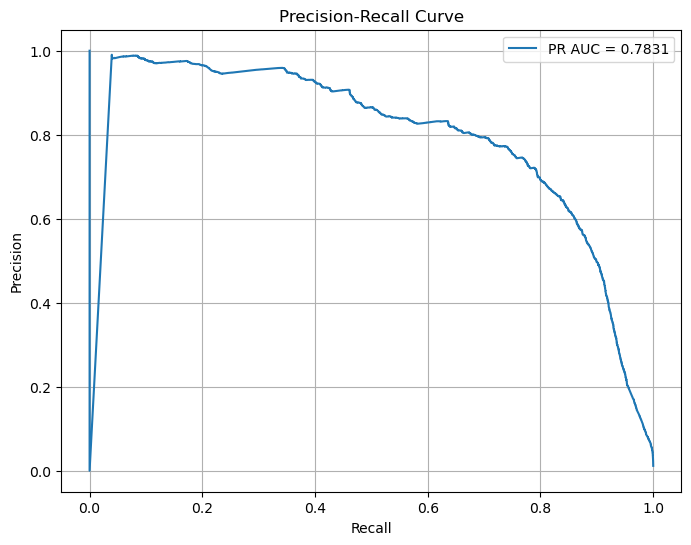

In [52]:
best_model_idx = np.argmax([h["val_accuracy"][-1] for h in histories])
best_model = models[best_model_idx]

y_pred_probs = best_model.predict(X_reshaped.reshape(-1, timesteps, X_reshaped.shape[1] // timesteps)).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)
plot_pr_curve(y, y_pred_probs)

In [53]:
print("\nFinal Classification Report:")
print(classification_report(y, y_pred))


Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1787181
           1       0.43      0.91      0.59     20941

    accuracy                           0.99   1808122
   macro avg       0.72      0.95      0.79   1808122
weighted avg       0.99      0.99      0.99   1808122



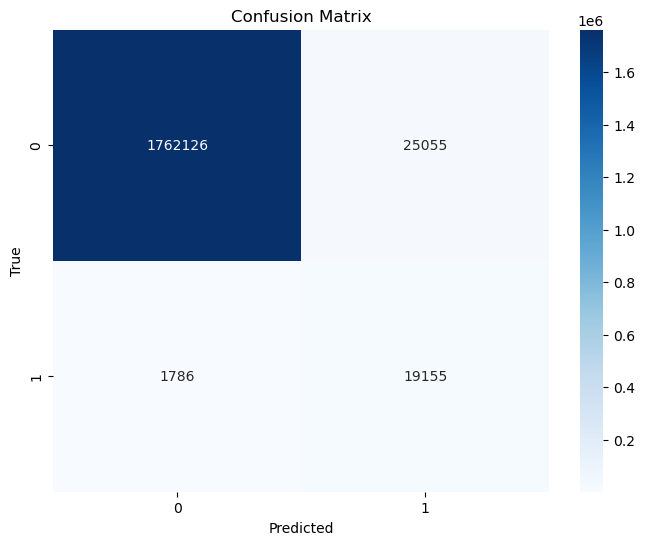

In [54]:
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [55]:
best_model.save("models/bidirectional_lstm_with_attention.h5")
print("Model saved at 'models/bidirectional_lstm_with_attention.h5'")

Model saved at 'models/bidirectional_lstm_with_attention.h5'
